In [1]:
# Cell 1 - imports & settings
%matplotlib inline
import random
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

random.seed(42)
np.random.seed(42)


In [2]:
# Cell 2 - data generator (synthetic cases)
def generate_patient_case_v2(diseases=None, symptom_list=None, noise_prob=0.05):
    """
    Generate a synthetic patient case.
    - diseases: list of disease names
    - symptom_list: ordered list of symptom names
    - noise_prob: probability to flip a symptom bit (simulates measurement noise)
    Returns: (symptom_dict, true_disease)
    """
    if diseases is None:
        diseases = ["Flu", "COVID", "Dengue"]
    if symptom_list is None:
        symptom_list = ["fever", "cough", "fatigue", "ache", "rash"]

    # Define (toy) disease -> symptom probabilities (P(symptom=1 | disease))
    # Keep interpretable probabilities (you can change these later)
    disease_symptom_probs = {
        "Flu":    {"fever":0.85, "cough":0.7,  "fatigue":0.6, "ache":0.5, "rash":0.05},
        "COVID":  {"fever":0.8,  "cough":0.85, "fatigue":0.7, "ache":0.3, "rash":0.02},
        "Dengue": {"fever":0.9,  "cough":0.1,  "fatigue":0.8, "ache":0.7, "rash":0.4}
    }

    true_disease = random.choice(diseases)
    probs = disease_symptom_probs[true_disease]

    symptoms = {}
    for s in symptom_list:
        p = probs.get(s, 0.1)
        val = 1 if random.random() < p else 0
        # add measurement noise
        if random.random() < noise_prob:
            val = 1 - val
        symptoms[s] = val

    return symptoms, true_disease

# Quick sanity test
print(generate_patient_case_v2())


({'fever': 1, 'cough': 0, 'fatigue': 1, 'ache': 1, 'rash': 1}, 'Dengue')


In [3]:
# Cell 3 - LearningDiagnosisAgent (incremental Naive Bayes using log-probs)
class LearningDiagnosisAgent:
    def __init__(self, diseases, symptoms, laplace=1.0):
        self.diseases = list(diseases)
        self.symptoms = list(symptoms)
        self.laplace = laplace

        # counts
        self.disease_counts = {d: 0.0 for d in self.diseases}     # N(d)
        # P(symptom=1 | disease) counts: count_1[d][s] and count_total[d]
        self.count_1 = {d: {s: 0.0 for s in self.symptoms} for d in self.diseases}
        self.count_total = {d: 0.0 for d in self.diseases}

        # initial uniform prior (small pseudo-counts via laplace)
        for d in self.diseases:
            self.disease_counts[d] = self.laplace
            self.count_total[d] = 2.0 * self.laplace  # to avoid zero division
            for s in self.symptoms:
                self.count_1[d][s] = self.laplace

    def _log_prior(self, d):
        total = sum(self.disease_counts.values())
        return math.log(self.disease_counts[d] / total)

    def _log_likelihood(self, d, patient_symptoms):
        """Compute log P(symptoms | disease) under independent symptom assumption."""
        logp = 0.0
        # estimated P(symptom=1 | d) with Laplace smoothing
        for s in self.symptoms:
            p1 = (self.count_1[d][s]) / (self.count_total[d])
            # numerical stability clamps
            p1 = min(max(p1, 1e-6), 1 - 1e-6)
            if patient_symptoms.get(s, 0) == 1:
                logp += math.log(p1)
            else:
                logp += math.log(1 - p1)
        return logp

    def predict(self, patient_symptoms):
        """Return the disease with highest posterior (unnormalized log-prob)."""
        best = None
        best_score = -1e99
        for d in self.diseases:
            score = self._log_prior(d) + self._log_likelihood(d, patient_symptoms)
            if score > best_score:
                best_score = score
                best = d
        return best

    def learn(self, patient_symptoms, true_disease):
        """Incremental update of counts using one labeled instance."""
        # update disease counts and totals
        self.disease_counts[true_disease] += 1.0
        self.count_total[true_disease] += 1.0
        for s in self.symptoms:
            if patient_symptoms.get(s, 0) == 1:
                self.count_1[true_disease][s] += 1.0

    def summary(self):
        """Simple readable summary of learned probabilities."""
        out = {}
        for d in self.diseases:
            probs = {s: self.count_1[d][s] / self.count_total[d] for s in self.symptoms}
            prior = self.disease_counts[d] / sum(self.disease_counts.values())
            out[d] = {"prior": prior, "P(symptom|d)": probs}
        return out


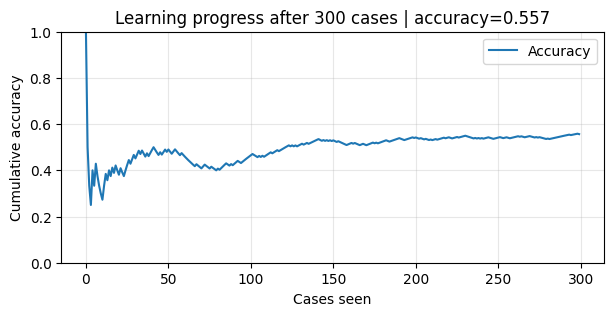

Final accuracy: 0.5566666666666666
Learned model summary (priors and P(symptom|d)):
{'COVID': {'P(symptom|d)': {'ache': 0.3829787234042553,
                            'cough': 0.8191489361702128,
                            'fatigue': 0.6702127659574468,
                            'fever': 0.7872340425531915,
                            'rash': 0.05319148936170213},
           'prior': 0.3069306930693069},
 'Dengue': {'P(symptom|d)': {'ache': 0.6698113207547169,
                             'cough': 0.16037735849056603,
                             'fatigue': 0.8113207547169812,
                             'fever': 0.8113207547169812,
                             'rash': 0.330188679245283},
            'prior': 0.3465346534653465},
 'Flu': {'P(symptom|d)': {'ache': 0.5660377358490566,
                          'cough': 0.6792452830188679,
                          'fatigue': 0.6415094339622641,
                          'fever': 0.8584905660377359,
                          'rash': 

In [4]:
# Cell 4 - incremental training loop with live accuracy visualization
diseases = ["Flu", "COVID", "Dengue"]
symptoms = ["fever", "cough", "fatigue", "ache", "rash"]

agent = LearningDiagnosisAgent(diseases, symptoms, laplace=1.0)

n_cases = 300       # total simulated patient cases
report_every = 20   # plot every this many steps
noise_prob = 0.05

accuracies = []
seen = 0
correct = 0

for step in range(1, n_cases + 1):
    pat_sym, true_label = generate_patient_case_v2(diseases=diseases, symptom_list=symptoms, noise_prob=noise_prob)
    pred = agent.predict(pat_sym)
    if pred == true_label:
        correct += 1
    seen += 1
    acc = correct / seen
    accuracies.append(acc)

    # agent learns from the true label (incremental)
    agent.learn(pat_sym, true_label)

    # visualization every few steps
    if step % report_every == 0 or step == n_cases:
        clear_output(wait=True)
        plt.figure(figsize=(7,3))
        plt.plot(accuracies, label="Accuracy")
        plt.xlabel("Cases seen")
        plt.ylabel("Cumulative accuracy")
        plt.ylim(0,1)
        plt.grid(alpha=0.3)
        plt.title(f"Learning progress after {step} cases | accuracy={acc:.3f}")
        plt.legend()
        plt.show()

# final summary
print("Final accuracy:", accuracies[-1])
print("Learned model summary (priors and P(symptom|d)):")
import pprint; pprint.pprint(agent.summary())


In [5]:
# Cell 5 - evaluate on held-out synthetic set and show confusion matrix
def evaluate_agent(agent, n_test=200, diseases=None, symptoms=None, noise_prob=0.05):
    if diseases is None: diseases = agent.diseases
    if symptoms is None: symptoms = agent.symptoms

    y_true = []
    y_pred = []
    for _ in range(n_test):
        pat_sym, true_label = generate_patient_case_v2(diseases=diseases, symptom_list=symptoms, noise_prob=noise_prob)
        pred = agent.predict(pat_sym)
        y_true.append(true_label)
        y_pred.append(pred)

    # confusion matrix
    labels = diseases
    mat = np.zeros((len(labels), len(labels)), dtype=int)
    idx = {l:i for i,l in enumerate(labels)}
    for t,p in zip(y_true, y_pred):
        mat[idx[t], idx[p]] += 1

    # print matrix neatly
    print("Confusion matrix (rows=true, cols=pred):")
    print("labels:", labels)
    print(mat)
    accuracy = np.trace(mat) / np.sum(mat)
    print(f"Test accuracy: {accuracy:.3f}")
    return mat, labels

mat, labels = evaluate_agent(agent, n_test=300, diseases=diseases, symptoms=symptoms, noise_prob=0.05)


Confusion matrix (rows=true, cols=pred):
labels: ['Flu', 'COVID', 'Dengue']
[[38 30 33]
 [25 62 17]
 [ 9  3 83]]
Test accuracy: 0.610


In [ ]:
# Cell 6 - simple save/load using numpy (pickle-like)
import json

def save_model(agent, filename="diagnosis_model.json"):
    model = {
        "diseases": agent.diseases,
        "symptoms": agent.symptoms,
        "disease_counts": agent.disease_counts,
        "count_1": agent.count_1,
        "count_total": agent.count_total,
        "laplace": agent.laplace
    }
    # convert numpy types to python floats if any
    with open(filename, "w") as f:
        json.dump(model, f)
    print("Saved model to", filename)

def load_model(filename="diagnosis_model.json"):
    with open(filename, "r") as f:
        model = json.load(f)
    ag = LearningDiagnosisAgent(model["diseases"], model["symptoms"], laplace=model.get("laplace",1.0))
    ag.disease_counts = {d: float(v) for d,v in model["disease_counts"].items()}
    ag.count_1 = {d: {s: float(v) for s,v in model["count_1"][d].items()} for d in model["count_1"]}
    ag.count_total = {d: float(v) for d,v in model["count_total"].items()}
    print("Loaded model from", filename)
    return ag

# Example: save model
save_model(agent)
# and to load later: agent2 = load_model("diagnosis_model.json")


Saved model to diagnosis_model.json
